# Public sentiment analysis on the Twitter dataset based on the Australian government COVID-19 Policy about covid19au, lockdown, quarantine, social distancing, vaccine,facemask

## <a id='1'>1. Import Libraries</a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

#Load the plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sn
from PIL import Image

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB



# To identify the sentiment of text
#from textblob import TextBlob
#from textblob.sentiments import NaiveBayesAnalyzer
#from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from collections import Counter

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sudarshanreddyambati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sudarshanreddyambati/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sudarshanreddyambati/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sudarshanreddyambati/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/sudarshanreddyambati/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sudarshanreddyambati/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[

## <a id='2'>2. Text Pre-processing</a> 

In [2]:
class Preprocessing:
    def __int__(self):

        pass

    def remove_pattern(self,text, pattern_regex):
        # findall() finds *all* the matches and returns them as a list of strings, with each string representing one match
        r = re.findall(pattern_regex, text)
        for i in r:
            text = re.sub(i, '', text)

        return text




    def data_preprocessing(self,tweets_df):
        tweets_df['tidy_tweets'] = np.vectorize(self.remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
        cleaned_tweets = []
        for index, row in tweets_df.iterrows():
            # Here we are filtering out all the words that contains link
            # In below line, it take each tweets from the dataframe and remove link from that
            words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]

            # Then append into the new dataframe
            cleaned_tweets.append(' '.join(words_without_links))

        tweets_df['tidy_tweets'] = cleaned_tweets

        tweets_df = tweets_df[tweets_df['tidy_tweets'] != '']

        # Dropping duplicate rows
        tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)

        # Resetting index
        tweets_df = tweets_df.reset_index(drop=True)

        # Removing Punctuations, Numbers and Special characters
        tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

        # Removing Stop words
        stopwords_set = set(stopwords)
        cleaned_tweets = []

        for index, row in tweets_df.iterrows():
            # filtering out all the stopwords
            words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if
                                       not word in stopwords_set and '#' not in word.lower()]

            # finally creating tweets list of tuples containing stopwords(list) and sentimentType
            cleaned_tweets.append(' '.join(words_without_stopwords))

        tweets_df['absolute_tidy_tweets'] = cleaned_tweets


        # Tokenize 'absolute_tidy_tweets'
        tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())

        # Converting words to Lemma
        word_lemmatizer = WordNetLemmatizer()

        # Tokenization using above defined object
        tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])

        # Joining all tokens into sentences
        for i, tokens in enumerate(tokenized_tweet):
            # join function is used to join token into sentences
            tokenized_tweet[i] = ' '.join(tokens)

        tweets_df['absolute_tidy_tweets'] = tokenized_tweet

        return tweets_df



### <a id='3'>3. Fetch sentiments</a>
To proceed further, we need to know the sentiment type of every tweet, that can be done using: <br/>
    __a. Using NLTK's SentimentIntensityAnalyzer <br/>__

In [3]:
class Sentiment_analysis:
    def __int__(self):
        pass

    
    def fetch_sentiment_using_SIA(self,text):
        # Making an object of analyzer
        score=""
        sid = SentimentIntensityAnalyzer()

        # The below function takes text as an input and return the polarity score Such as positive,negative and neutral
        polarity_scores = sid.polarity_scores(text) 
        
        if polarity_scores['compound'] >= 0.05 :
            
            score="pos"
 
        elif polarity_scores['compound'] <= - 0.05 :
            score="neg"
        else:
            score="neutral"
        

        return score

    def perform_sentiment_function(self,tweets_df):
        # Calling function which will return the positive,negative and neutral results
        sentiments_using_SIA = tweets_df.absolute_tidy_tweets.apply(lambda tweet: self.fetch_sentiment_using_SIA(tweet))

        tweets_df['sentiment']=sentiments_using_SIA

        return tweets_df

### Most Common words

In [4]:
def most_common_words(text):
   
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common(15)
    
    x, y=[], []
    for word,count in most[:40]:
      
        x.append(word)
        y.append(count)
            
    return sns.barplot(x=y,y=x)

## <a id='4'>4. Story Generation and Visualization</a>
#### <a id='4A'>A. Most common words in positive tweets</a>
Answer can be best found using WordCloud

In [5]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800,background_color='white', height=500, random_state=21, max_font_size=100, relative_scaling=0.5).generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

# Monthly tweets visualization

In [6]:
#Analysed the dataset based on the monthly tweets done positive, negative and neutral
def tweets_monthly_count(senti_database):
    by_monthly = pd.to_datetime(senti_database['date']).dt.to_period('M')
    return by_monthly

def drawing_the_plot(data):
    
    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars1 = data.loc[(data.index.get_level_values('sentiment') =="neg")].values
    bars2 = data.loc[(data.index.get_level_values('sentiment') =="pos")].values
    bars3 = data.loc[(data.index.get_level_values('sentiment') =="neutral")].values
    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3=[y + barWidth for y in r2]
    plt.figure(figsize=(15, 5))
    # Make the plot
    plt.bar(r1, bars1, color='#FF4933', width=barWidth, edgecolor='white', label='neg')
    plt.bar(r2, bars2, color='#68FF33', width=barWidth, edgecolor='white', label='pos')
    plt.bar(r3, bars3, color='#3390FF', width=barWidth, edgecolor='white', label='neutral')
    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], data.index.get_level_values('months').unique())
    # Create legend & Show graphic
    plt.legend()
    plt.title("Monthly tweets")#title change according to graph
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.show()

# Preprocessing each data one by one
---------------------------------------------------------------
Each dataset will be preprocess one by one. All preprocessing function will be applied on each data. The output figure will shown and cleaned data will be stored in a folder for further preprocessing.

# 1 - covid19au

# Data Collection

In [7]:
# df_covid19 = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
#     'covid19au near:"Perth" within:5000km since:2020-03-01 until:2020-10-31').get_items(), 100000))[['date', 'content']]

In [8]:
# df_covid19.to_csv('covid19au.csv', index=False) #Store the collected tweets into local system 

##### 1 - Reading Raw dataset

In [9]:
raw_df=pd.read_csv("covid19au.csv")
raw_df.head(3)

date  \
0  2020-10-30 02:49:20+00:00   
1  2020-10-29 03:12:56+00:00   
2  2020-10-29 00:47:25+00:00   

                                             content  
0  Talking all things Queensland borders at today...  
1  All hand sanitiser sold in Australia should co...  
2  Saturday night a blokes night will occur as ou...

##### 2 - Renaming Columns

In [10]:

# As the column has no name so i am renaming the column in this code
raw_df.rename(columns = {"content":'tweets'}, inplace = True)
raw_df.head(3)

date  \
0  2020-10-30 02:49:20+00:00   
1  2020-10-29 03:12:56+00:00   
2  2020-10-29 00:47:25+00:00   

                                              tweets  
0  Talking all things Queensland borders at today...  
1  All hand sanitiser sold in Australia should co...  
2  Saturday night a blokes night will occur as ou...

##### 3 - Preprocessing the data

In [11]:
# making an object of the preprocessing class

pro=Preprocessing()

# Cleaning  tweets
clean_tweets=pro.data_preprocessing(raw_df)

clean_tweets.head(5)

<ipython-input-2-a8680800a29a>:39: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


date  \
0  2020-10-30 02:49:20+00:00   
1  2020-10-29 03:12:56+00:00   
2  2020-10-29 00:47:25+00:00   
3  2020-10-24 23:45:24+00:00   
4  2020-10-24 09:13:34+00:00   

                                              tweets  \
0  Talking all things Queensland borders at today...   
1  All hand sanitiser sold in Australia should co...   
2  Saturday night a blokes night will occur as ou...   
3       Nailed it #covid19au https://t.co/5VYEluC9mX   
4  @DebFrecklington @AFL 1 week until the electio...   

                                         tidy_tweets  \
0  Talking all things Queensland borders at today...   
1  All hand sanitiser sold in Australia should co...   
2  Saturday night a blokes night will occur as ou...   
3                               Nailed it #covid19au   
4  @DebFrecklington @AFL 1 week until the electio...   

                                absolute_tidy_tweets  
0      Talking thing Queensland border today presser  
1  All hand sanitiser sold Australia contain enou...  
2  Saturday night bloke night occur wife go annua...  
3                                             Nailed  
4  DebFrecklington AFL week election pandemic sti...

##### 4 - Analyzing text statistics
First, I’ll take a look at the number of characters present in each sentence. This can give us a rough idea about the tweets length.

<AxesSubplot:>

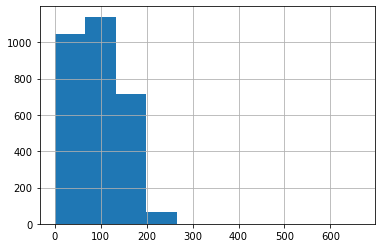

In [12]:
clean_tweets['absolute_tidy_tweets'].str.len().hist()

The histogram shows that tweets range from 0 to 600 characters and generally, average length is between 0 and 250 

Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each tweets.

<AxesSubplot:>

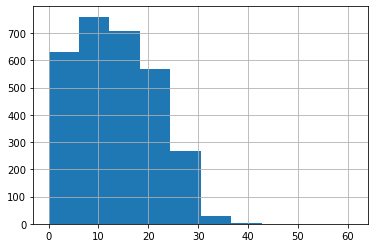

In [13]:
clean_tweets["absolute_tidy_tweets"].str.split().\
    map(lambda x: len(x)).\
    hist()

It is clear that the number of words in tweets ranges from 0 to 60 and mostly falls between 2 to 30 words.

###### 5 - Top 15 most common words

<AxesSubplot:>

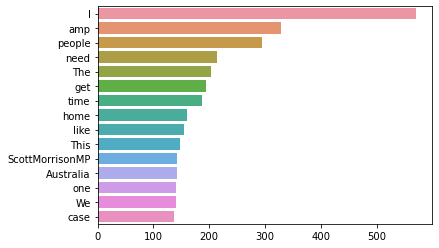

In [14]:
most_common_words(clean_tweets.absolute_tidy_tweets)

##### 6 - Extracting the Sentiments analysis

In [15]:
# Creating sentiment of the tweets one by one by calling the above function
senti=Sentiment_analysis()
sentiments=senti.perform_sentiment_function(clean_tweets)
sentiments.head(5)

date  \
0  2020-10-30 02:49:20+00:00   
1  2020-10-29 03:12:56+00:00   
2  2020-10-29 00:47:25+00:00   
3  2020-10-24 23:45:24+00:00   
4  2020-10-24 09:13:34+00:00   

                                              tweets  \
0  Talking all things Queensland borders at today...   
1  All hand sanitiser sold in Australia should co...   
2  Saturday night a blokes night will occur as ou...   
3       Nailed it #covid19au https://t.co/5VYEluC9mX   
4  @DebFrecklington @AFL 1 week until the electio...   

                                         tidy_tweets  \
0  Talking all things Queensland borders at today...   
1  All hand sanitiser sold in Australia should co...   
2  Saturday night a blokes night will occur as ou...   
3                               Nailed it #covid19au   
4  @DebFrecklington @AFL 1 week until the electio...   

                                absolute_tidy_tweets sentiment  
0      Talking thing Queensland border today presser   neutral  
1  All hand sanitiser sold Australia contain enou...       pos  
2  Saturday night bloke night occur wife go annua...       pos  
3                                             Nailed   neutral  
4  DebFrecklington AFL week election pandemic sti...       neg

##### 7 - Graphs

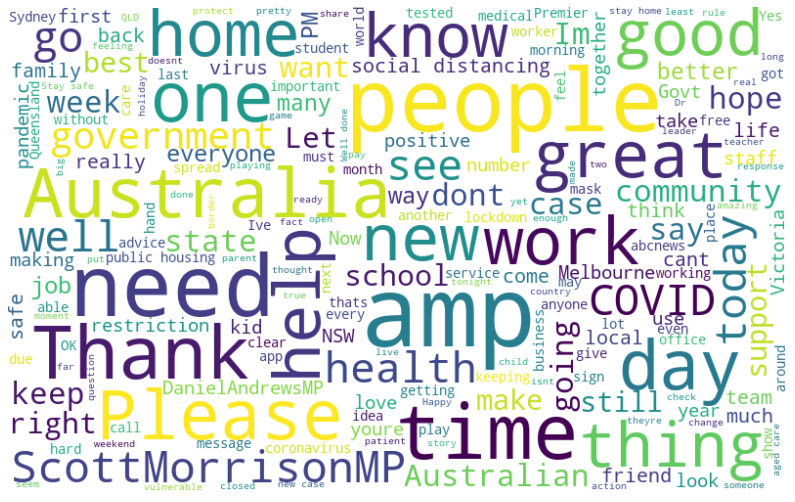

In [16]:
# Wordcloud for positive words
all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'pos']])

generate_wordcloud(all_words)

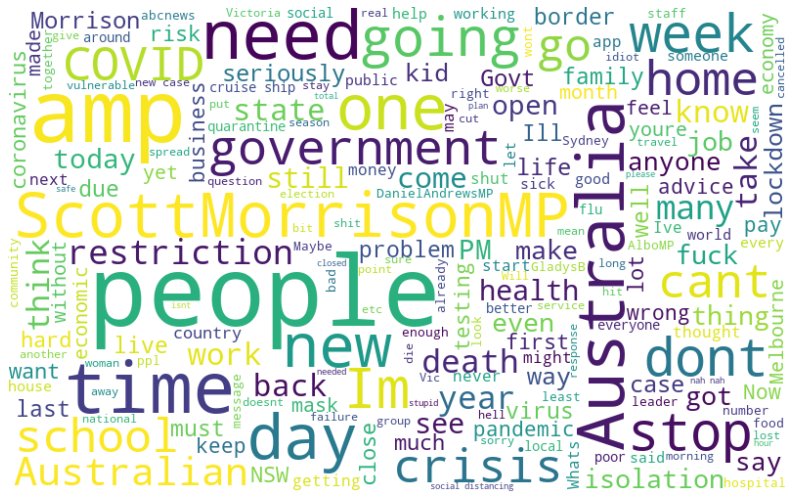

In [17]:
# negative tweets words

all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'neg']])
generate_wordcloud(all_words)

##### 8 - Total number of sentiments

<BarContainer object of 3 artists>

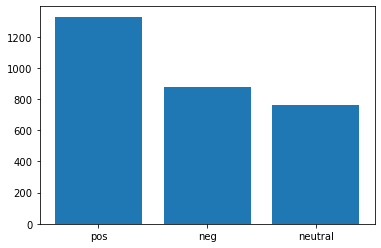

In [18]:
plt.bar(sentiments.sentiment.value_counts().index,
        sentiments.sentiment.value_counts())

##### 9 - Storing processed dataset

In [19]:
sentiments.to_csv("clean_covid19au.csv")

In [20]:
data=pd.read_csv("clean_covid19au.csv")

In [21]:
data.head(4)

Unnamed: 0                       date  \
0           0  2020-10-30 02:49:20+00:00   
1           1  2020-10-29 03:12:56+00:00   
2           2  2020-10-29 00:47:25+00:00   
3           3  2020-10-24 23:45:24+00:00   

                                              tweets  \
0  Talking all things Queensland borders at today...   
1  All hand sanitiser sold in Australia should co...   
2  Saturday night a blokes night will occur as ou...   
3       Nailed it #covid19au https://t.co/5VYEluC9mX   

                                         tidy_tweets  \
0  Talking all things Queensland borders at today...   
1  All hand sanitiser sold in Australia should co...   
2  Saturday night a blokes night will occur as ou...   
3                               Nailed it #covid19au   

                                absolute_tidy_tweets sentiment  
0      Talking thing Queensland border today presser   neutral  
1  All hand sanitiser sold Australia contain enou...       pos  
2  Saturday night bloke night occur wife go annua...       pos  
3                                             Nailed   neutral

In [22]:
data["months"] = tweets_monthly_count(data)
data.head(4)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Unnamed: 0                       date  \
0           0  2020-10-30 02:49:20+00:00   
1           1  2020-10-29 03:12:56+00:00   
2           2  2020-10-29 00:47:25+00:00   
3           3  2020-10-24 23:45:24+00:00   

                                              tweets  \
0  Talking all things Queensland borders at today...   
1  All hand sanitiser sold in Australia should co...   
2  Saturday night a blokes night will occur as ou...   
3       Nailed it #covid19au https://t.co/5VYEluC9mX   

                                         tidy_tweets  \
0  Talking all things Queensland borders at today...   
1  All hand sanitiser sold in Australia should co...   
2  Saturday night a blokes night will occur as ou...   
3                               Nailed it #covid19au   

                                absolute_tidy_tweets sentiment   months  
0      Talking thing Queensland border today presser   neutral  2020-10  
1  All hand sanitiser sold Australia contain enou...       pos  2020-10  
2  Saturday night bloke night occur wife go annua...       pos  2020-10  
3                                             Nailed   neutral  2020-10

In [23]:
summary = data.groupby(["months","sentiment"]).size()
print(summary)



months   sentiment
2020-03  neg          473
         neutral      418
         pos          655
2020-04  neg          208
         neutral      173
         pos          372
2020-05  neg           42
         neutral       33
         pos           75
2020-06  neg           16
         neutral       14
         pos           17
2020-07  neg           71
         neutral       63
         pos           97
2020-08  neg           52
         neutral       43
         pos           76
2020-09  neg           12
         neutral       13
         pos           33
2020-10  neg            2
         neutral        3
         pos            3
dtype: int64


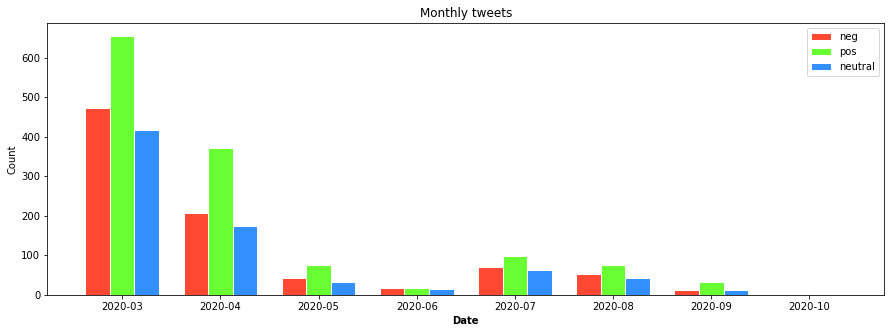

In [24]:
#Ploting the graph 
drawing_the_plot(summary)

### 2 - lockdown

In [25]:
# df_lockdown = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
#     'lockdown near:"Perth" within:5000km since:2020-03-01 until:2020-10-31').get_items(), 100000))[['date', 'content']]

In [26]:
# df_lockdown.to_csv('lockdown_senti.csv', index=False) #Store the collected tweets into local system 

##### 1 - Reading Raw dataset

In [27]:
raw_df=pd.read_csv("lockdown_senti.csv")
raw_df.head(3)

date  \
0  2020-10-30 23:56:05+00:00   
1  2020-10-30 23:48:39+00:00   
2  2020-10-30 23:32:28+00:00   

                                             content  
0  Lockdown works in the short term. But is it ul...  
1  Just to finish off Inktober2020 with a smile. ...  
2  Lmao Melb defs going into a 3rd and 4th lockdo...

##### 2 - Renaming Columns

In [28]:

# As the column has no name so i am renaming the column in this code
raw_df.rename(columns = {"content":'tweets'}, inplace = True)
raw_df.head(3)

date  \
0  2020-10-30 23:56:05+00:00   
1  2020-10-30 23:48:39+00:00   
2  2020-10-30 23:32:28+00:00   

                                              tweets  
0  Lockdown works in the short term. But is it ul...  
1  Just to finish off Inktober2020 with a smile. ...  
2  Lmao Melb defs going into a 3rd and 4th lockdo...

##### 3 - Preprocessing the data

In [29]:
# making an object of the preprocessing class

pro=Preprocessing()

# Cleaning  tweets
clean_tweets=pro.data_preprocessing(raw_df)

clean_tweets.head(5)

<ipython-input-2-a8680800a29a>:39: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


date  \
0  2020-10-30 23:56:05+00:00   
1  2020-10-30 23:48:39+00:00   
2  2020-10-30 23:32:28+00:00   
3  2020-10-30 23:26:27+00:00   
4  2020-10-30 21:58:31+00:00   

                                              tweets  \
0  Lockdown works in the short term. But is it ul...   
1  Just to finish off Inktober2020 with a smile. ...   
2  Lmao Melb defs going into a 3rd and 4th lockdo...   
3  I'm sorry, Britain.  Boris had failed you all ...   
4  @JCreatureTravel I wish more people thought li...   

                                         tidy_tweets  \
0  Lockdown works in the short term. But is it ul...   
1  Just to finish off Inktober2020 with a smile. ...   
2  Lmao Melb defs going into a 3rd and 4th lockdo...   
3  I'm sorry, Britain. Boris had failed you all a...   
4  @JCreatureTravel I wish more people thought li...   

                                absolute_tidy_tweets  
0  Lockdown work short term But ultimately best s...  
1  Just finish Inktober smile Thank reacted comme...  
2  Lmao Melb defs going rd th lockdown People ful...  
3  Im sorry Britain Boris failed week SAGE said i...  
4  JCreatureTravel I wish people thought like Its...

##### 4 - Analyzing text statistics
First, I’ll take a look at the number of characters present in each sentence. This can give us a rough idea about the tweets length.

<AxesSubplot:>

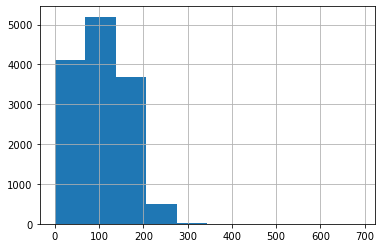

In [30]:
clean_tweets['absolute_tidy_tweets'].str.len().hist()

The histogram shows that tweets range from 0 to 700 characters and generally, 

Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each tweets.

<AxesSubplot:>

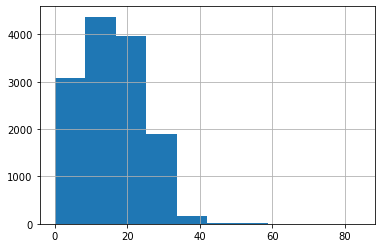

In [31]:
clean_tweets["absolute_tidy_tweets"].str.split().\
    map(lambda x: len(x)).\
    hist()

It is clear that the number of words in tweets ranges from 0 to 80 and mostly falls between 2 to 30 words.

###### 5 - Top 15 most common words

<AxesSubplot:>

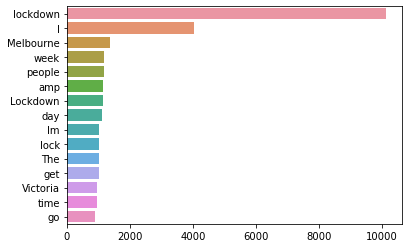

In [32]:
most_common_words(clean_tweets.absolute_tidy_tweets)

##### 6 - Extracting the Sentiments analysis

In [33]:
# Creating sentiment of the tweets one by one by calling the above function
senti=Sentiment_analysis()
sentiments=senti.perform_sentiment_function(clean_tweets)
sentiments.head(5)

date  \
0  2020-10-30 23:56:05+00:00   
1  2020-10-30 23:48:39+00:00   
2  2020-10-30 23:32:28+00:00   
3  2020-10-30 23:26:27+00:00   
4  2020-10-30 21:58:31+00:00   

                                              tweets  \
0  Lockdown works in the short term. But is it ul...   
1  Just to finish off Inktober2020 with a smile. ...   
2  Lmao Melb defs going into a 3rd and 4th lockdo...   
3  I'm sorry, Britain.  Boris had failed you all ...   
4  @JCreatureTravel I wish more people thought li...   

                                         tidy_tweets  \
0  Lockdown works in the short term. But is it ul...   
1  Just to finish off Inktober2020 with a smile. ...   
2  Lmao Melb defs going into a 3rd and 4th lockdo...   
3  I'm sorry, Britain. Boris had failed you all a...   
4  @JCreatureTravel I wish more people thought li...   

                                absolute_tidy_tweets sentiment  
0  Lockdown work short term But ultimately best s...       pos  
1  Just finish Inktober smile Thank reacted comme...       pos  
2  Lmao Melb defs going rd th lockdown People ful...       pos  
3  Im sorry Britain Boris failed week SAGE said i...       neg  
4  JCreatureTravel I wish people thought like Its...       pos

##### 7 - Graphs

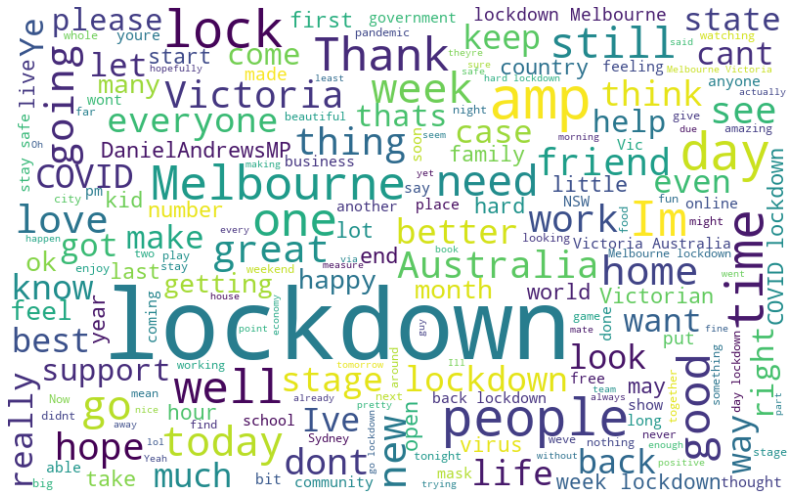

In [34]:
# Wordcloud for positive words
all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'pos']])

generate_wordcloud(all_words)

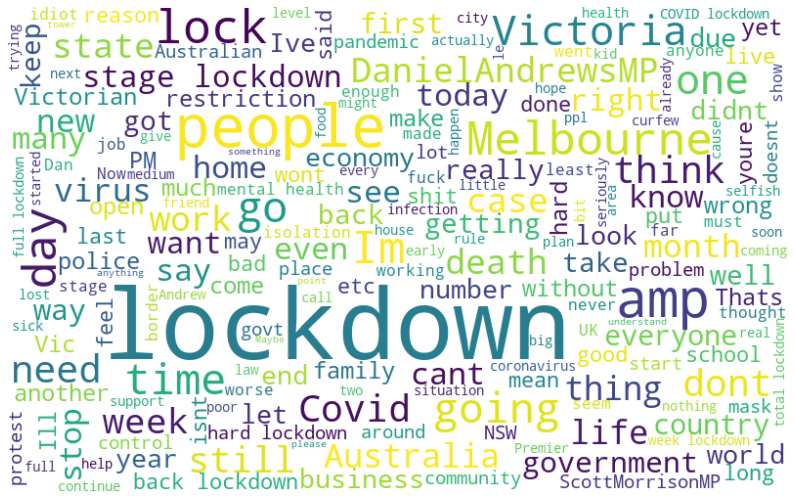

In [35]:
# negative tweets words

all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'neg']])
generate_wordcloud(all_words)

##### 8 - Total number of sentiments

<BarContainer object of 3 artists>

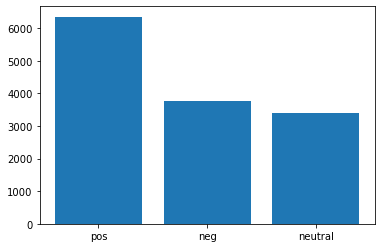

In [36]:
plt.bar(sentiments.sentiment.value_counts().index,
        sentiments.sentiment.value_counts())

##### 9 - Storing processed dataset

In [37]:
sentiments.to_csv("clean_lockdown_senti.csv")

In [38]:
data=pd.read_csv("clean_lockdown_senti.csv")

In [39]:
data.head(4)

Unnamed: 0                       date  \
0           0  2020-10-30 23:56:05+00:00   
1           1  2020-10-30 23:48:39+00:00   
2           2  2020-10-30 23:32:28+00:00   
3           3  2020-10-30 23:26:27+00:00   

                                              tweets  \
0  Lockdown works in the short term. But is it ul...   
1  Just to finish off Inktober2020 with a smile. ...   
2  Lmao Melb defs going into a 3rd and 4th lockdo...   
3  I'm sorry, Britain.  Boris had failed you all ...   

                                         tidy_tweets  \
0  Lockdown works in the short term. But is it ul...   
1  Just to finish off Inktober2020 with a smile. ...   
2  Lmao Melb defs going into a 3rd and 4th lockdo...   
3  I'm sorry, Britain. Boris had failed you all a...   

                                absolute_tidy_tweets sentiment  
0  Lockdown work short term But ultimately best s...       pos  
1  Just finish Inktober smile Thank reacted comme...       pos  
2  Lmao Melb defs going rd th lockdown People ful...       pos  
3  Im sorry Britain Boris failed week SAGE said i...       neg

In [40]:
data["months"] = tweets_monthly_count(data)
data.head(4)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Unnamed: 0                       date  \
0           0  2020-10-30 23:56:05+00:00   
1           1  2020-10-30 23:48:39+00:00   
2           2  2020-10-30 23:32:28+00:00   
3           3  2020-10-30 23:26:27+00:00   

                                              tweets  \
0  Lockdown works in the short term. But is it ul...   
1  Just to finish off Inktober2020 with a smile. ...   
2  Lmao Melb defs going into a 3rd and 4th lockdo...   
3  I'm sorry, Britain.  Boris had failed you all ...   

                                         tidy_tweets  \
0  Lockdown works in the short term. But is it ul...   
1  Just to finish off Inktober2020 with a smile. ...   
2  Lmao Melb defs going into a 3rd and 4th lockdo...   
3  I'm sorry, Britain. Boris had failed you all a...   

                                absolute_tidy_tweets sentiment   months  
0  Lockdown work short term But ultimately best s...       pos  2020-10  
1  Just finish Inktober smile Thank reacted comme...       pos  2020-10  
2  Lmao Melb defs going rd th lockdown People ful...       pos  2020-10  
3  Im sorry Britain Boris failed week SAGE said i...       neg  2020-10

In [41]:
summary = data.groupby(["months","sentiment"]).size()
print(summary)



months   sentiment
2020-03  neg           647
         neutral       722
         pos           986
2020-04  neg           220
         neutral       220
         pos           403
2020-05  neg           252
         neutral       233
         pos           444
2020-06  neg           172
         neutral       206
         pos           313
2020-07  neg           811
         neutral       786
         pos          1393
2020-08  neg           689
         neutral       567
         pos          1302
2020-09  neg           522
         neutral       399
         pos           882
2020-10  neg           442
         neutral       273
         pos           629
dtype: int64


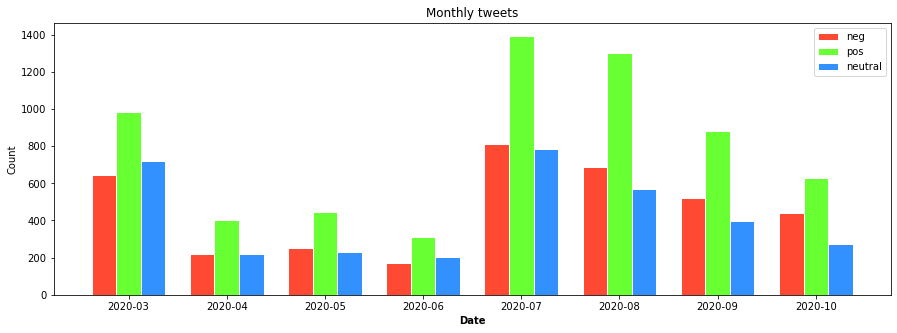

In [42]:
#Ploting the graph 
drawing_the_plot(summary)

### 3 - quarantine

In [43]:
# df_quarantine = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
#     'quarantine near:"Perth" within:5000km since:2020-03-01 until:2020-10-31').get_items(), 100000))[['date', 'content']]

In [44]:
# df_quarantine.to_csv('quarantine.csv', index=False) #Store the collected tweets into local system 

##### 1 - Reading Raw dataset

In [45]:
raw_df=pd.read_csv("quarantine.csv")
raw_df.head(3)

date  \
0  2020-10-30 21:22:16+00:00   
1  2020-10-30 20:10:28+00:00   
2  2020-10-30 19:09:21+00:00   

                                             content  \
0                                        quarantine?   
1  cristiano ronaldo tested negative covid 19 qua...   
2  evening cravings 💕 hightea quarantine style co...   

                                          POS_tagged  \
0                 [('quarantine', 'n'), ('?', None)]   
1  [('cristiano', 'n'), ('ronaldo', 'n'), ('teste...   
2  [('evening', 'v'), ('cravings', 'n'), ('💕', 'n...   

                                               Lemma  Polarity  Sentiment  
0                                        quarantine?       0.0          0  
1  cristianoronaldotestnegativecovid19quarantine....       0.0          0  
2  evencraving💕highteaquarantinestylecookyhightea...       0.0          0

##### 2 - Droping unnecessary Columns

In [46]:
# As these files contain some unnecessary columns. or some columns we need to calculte again 
#so i am removing before further processing
raw_df.drop(raw_df.columns[[2,3,4,5]], axis = 1, inplace = True)
# As the column has no name so i am renaming the column in this code
raw_df.rename(columns = {"content":'tweets'}, inplace = True)
raw_df.head(3)

date  \
0  2020-10-30 21:22:16+00:00   
1  2020-10-30 20:10:28+00:00   
2  2020-10-30 19:09:21+00:00   

                                              tweets  
0                                        quarantine?  
1  cristiano ronaldo tested negative covid 19 qua...  
2  evening cravings 💕 hightea quarantine style co...

##### 3 - Preprocessing the data

In [47]:
# making an object of the preprocessing class

pro=Preprocessing()

# Cleaning  tweets
clean_tweets=pro.data_preprocessing(raw_df)

clean_tweets.head(5)

<ipython-input-2-a8680800a29a>:39: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


date  \
0  2020-10-30 21:22:16+00:00   
1  2020-10-30 20:10:28+00:00   
2  2020-10-30 19:09:21+00:00   
3  2020-10-30 18:55:47+00:00   
4  2020-10-30 18:18:47+00:00   

                                              tweets  \
0                                        quarantine?   
1  cristiano ronaldo tested negative covid 19 qua...   
2  evening cravings 💕 hightea quarantine style co...   
3  today supposed d7 quarantine im restarting cou...   
4                        finally quarantine day 14 😌   

                                         tidy_tweets  \
0                                        quarantine?   
1  cristiano ronaldo tested negative covid 19 qua...   
2  evening cravings 💕 hightea quarantine style co...   
3  today supposed d7 quarantine im restarting cou...   
4                        finally quarantine day 14 😌   

                                absolute_tidy_tweets  
0                                         quarantine  
1  cristiano ronaldo tested negative covid quaran...  
2  evening craving hightea quarantine style cooky...  
3  today supposed quarantine im restarting countdown  
4                             finally quarantine day

##### 4 - Analyzing text statistics
First, I’ll take a look at the number of characters present in each sentence. This can give us a rough idea about the tweets length.

<AxesSubplot:>

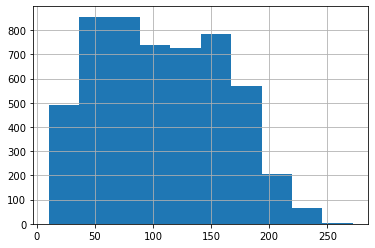

In [48]:
clean_tweets['absolute_tidy_tweets'].str.len().hist()

The histogram shows that tweets range from 0 to 250 characters and generally, 

Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each tweets.

<AxesSubplot:>

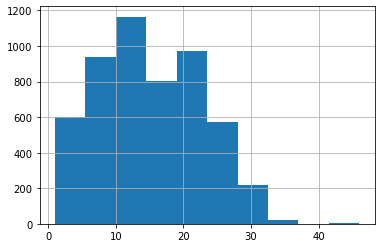

In [49]:
clean_tweets["absolute_tidy_tweets"].str.split().\
    map(lambda x: len(x)).\
    hist()

It is clear that the number of words in tweets ranges from 0 to 40 and mostly falls between 2 to 30 words.

###### 5 - Top 15 most common words

<AxesSubplot:>

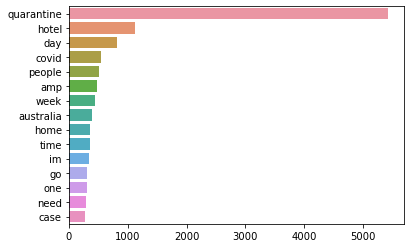

In [50]:
most_common_words(clean_tweets.absolute_tidy_tweets)

##### 6 - Extracting the Sentiments analysis

In [51]:
# Creating sentiment of the tweets one by one by calling the above function
senti=Sentiment_analysis()
sentiments=senti.perform_sentiment_function(clean_tweets)
sentiments.head(5)

date  \
0  2020-10-30 21:22:16+00:00   
1  2020-10-30 20:10:28+00:00   
2  2020-10-30 19:09:21+00:00   
3  2020-10-30 18:55:47+00:00   
4  2020-10-30 18:18:47+00:00   

                                              tweets  \
0                                        quarantine?   
1  cristiano ronaldo tested negative covid 19 qua...   
2  evening cravings 💕 hightea quarantine style co...   
3  today supposed d7 quarantine im restarting cou...   
4                        finally quarantine day 14 😌   

                                         tidy_tweets  \
0                                        quarantine?   
1  cristiano ronaldo tested negative covid 19 qua...   
2  evening cravings 💕 hightea quarantine style co...   
3  today supposed d7 quarantine im restarting cou...   
4                        finally quarantine day 14 😌   

                                absolute_tidy_tweets sentiment  
0                                         quarantine   neutral  
1  cristiano ronaldo tested negative covid quaran...       neg  
2  evening craving hightea quarantine style cooky...   neutral  
3  today supposed quarantine im restarting countdown   neutral  
4                             finally quarantine day   neutral

##### 7 - Graphs

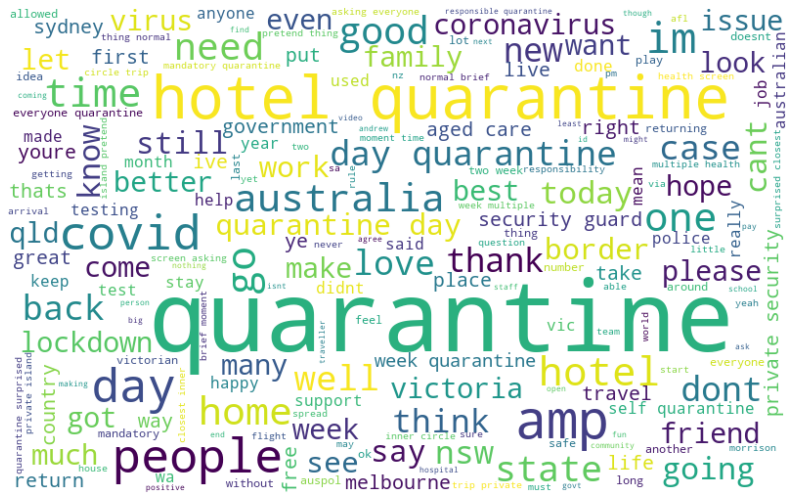

In [52]:
# Wordcloud for positive words
all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'pos']])

generate_wordcloud(all_words)

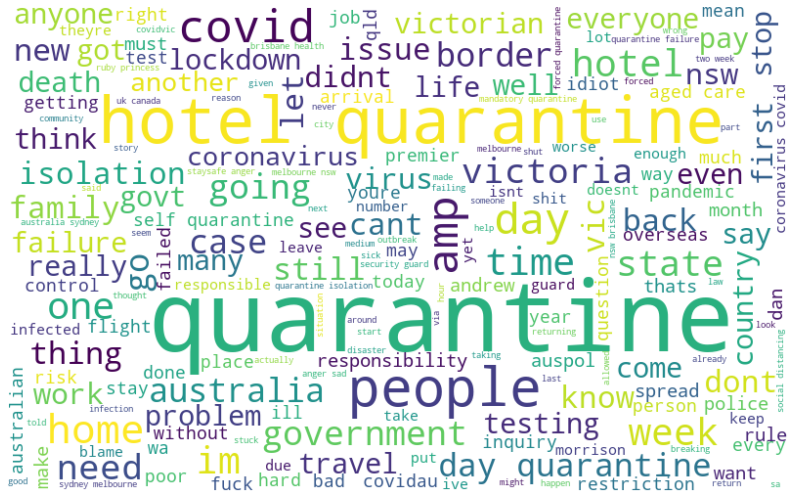

In [53]:
# negative tweets words

all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'neg']])
generate_wordcloud(all_words)

##### 8 - Total number of sentiments

<BarContainer object of 3 artists>

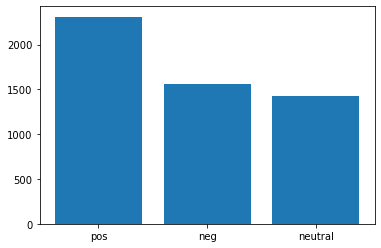

In [54]:
plt.bar(sentiments.sentiment.value_counts().index,
        sentiments.sentiment.value_counts())

##### 9 - Storing processed dataset

In [55]:
sentiments.to_csv("clean_quarantine.csv")

In [56]:
data=pd.read_csv("clean_quarantine.csv")

In [57]:
data.head(4)

Unnamed: 0                       date  \
0           0  2020-10-30 21:22:16+00:00   
1           1  2020-10-30 20:10:28+00:00   
2           2  2020-10-30 19:09:21+00:00   
3           3  2020-10-30 18:55:47+00:00   

                                              tweets  \
0                                        quarantine?   
1  cristiano ronaldo tested negative covid 19 qua...   
2  evening cravings 💕 hightea quarantine style co...   
3  today supposed d7 quarantine im restarting cou...   

                                         tidy_tweets  \
0                                        quarantine?   
1  cristiano ronaldo tested negative covid 19 qua...   
2  evening cravings 💕 hightea quarantine style co...   
3  today supposed d7 quarantine im restarting cou...   

                                absolute_tidy_tweets sentiment  
0                                         quarantine   neutral  
1  cristiano ronaldo tested negative covid quaran...       neg  
2  evening craving hightea quarantine style cooky...   neutral  
3  today supposed quarantine im restarting countdown   neutral

In [58]:
data["months"] = tweets_monthly_count(data)
data.head(4)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Unnamed: 0                       date  \
0           0  2020-10-30 21:22:16+00:00   
1           1  2020-10-30 20:10:28+00:00   
2           2  2020-10-30 19:09:21+00:00   
3           3  2020-10-30 18:55:47+00:00   

                                              tweets  \
0                                        quarantine?   
1  cristiano ronaldo tested negative covid 19 qua...   
2  evening cravings 💕 hightea quarantine style co...   
3  today supposed d7 quarantine im restarting cou...   

                                         tidy_tweets  \
0                                        quarantine?   
1  cristiano ronaldo tested negative covid 19 qua...   
2  evening cravings 💕 hightea quarantine style co...   
3  today supposed d7 quarantine im restarting cou...   

                                absolute_tidy_tweets sentiment   months  
0                                         quarantine   neutral  2020-10  
1  cristiano ronaldo tested negative covid quaran...       neg  2020-10  
2  evening craving hightea quarantine style cooky...   neutral  2020-10  
3  today supposed quarantine im restarting countdown   neutral  2020-10

In [59]:
summary = data.groupby(["months","sentiment"]).size()
print(summary)

months   sentiment
2020-03  neg          394
         neutral      458
         pos          603
2020-04  neg          244
         neutral      294
         pos          412
2020-05  neg           56
         neutral       96
         pos          129
2020-06  neg           64
         neutral       55
         pos          112
2020-07  neg          206
         neutral      127
         pos          271
2020-08  neg          233
         neutral      144
         pos          304
2020-09  neg          190
         neutral      144
         pos          240
2020-10  neg          172
         neutral      112
         pos          239
dtype: int64


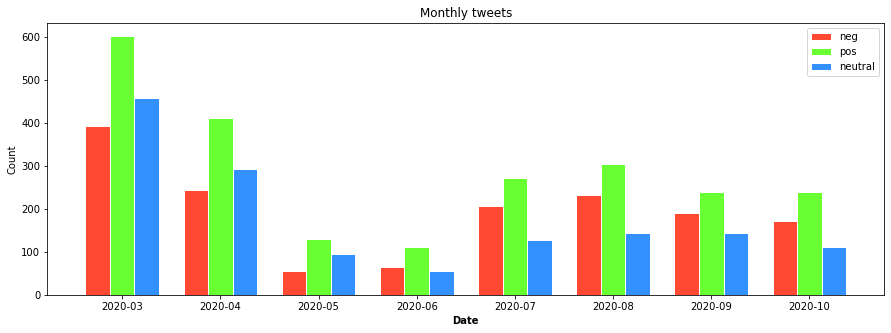

In [60]:
#Ploting the graph 
drawing_the_plot(summary)

### 4 - social distancing

In [61]:
# df_soc_dis = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
#     'social distancing near:"Perth" within:5000km since:2020-03-01 until:2020-10-31').get_items(), 100000))[['date', 'content']]

In [62]:
# df_soc_dis.to_csv('soc_distanc_senti.csv', index=False) #Store the collected tweets into local system 

##### 1 - Reading Raw dataset

In [63]:
raw_df=pd.read_csv("soc_distanc_senti.csv")
raw_df.head(3)

date  \
0  2020-10-30 22:06:12+00:00   
1  2020-10-30 21:09:12+00:00   
2  2020-10-30 19:36:57+00:00   

                                             content  
0  Social Distancing w/ @GAROFALI by @PatSupsiri ...  
1  Really impressed by @Jetstar_NZ strongly recom...  
2  @EmilyQMD Great work @EmilyQMD In Australia we...

##### 2 - Renaming Columns

In [64]:

# As the column has no name so i am renaming the column in this code
raw_df.rename(columns = {"content":'tweets'}, inplace = True)
raw_df.head(3)

date  \
0  2020-10-30 22:06:12+00:00   
1  2020-10-30 21:09:12+00:00   
2  2020-10-30 19:36:57+00:00   

                                              tweets  
0  Social Distancing w/ @GAROFALI by @PatSupsiri ...  
1  Really impressed by @Jetstar_NZ strongly recom...  
2  @EmilyQMD Great work @EmilyQMD In Australia we...

##### 3 - Preprocessing the data

In [65]:
# making an object of the preprocessing class

pro=Preprocessing()

# Cleaning  tweets
clean_tweets=pro.data_preprocessing(raw_df)

clean_tweets.head(5)

<ipython-input-2-a8680800a29a>:39: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


date  \
0  2020-10-30 22:06:12+00:00   
1  2020-10-30 21:09:12+00:00   
2  2020-10-30 19:36:57+00:00   
3  2020-10-30 11:51:33+00:00   
4  2020-10-30 11:04:50+00:00   

                                              tweets  \
0  Social Distancing w/ @GAROFALI by @PatSupsiri ...   
1  Really impressed by @Jetstar_NZ strongly recom...   
2  @EmilyQMD Great work @EmilyQMD In Australia we...   
3  @daddylongballz @washingtonpost Population esp...   
4  Tapi ada sedikit kelakar social distancing nnt...   

                                         tidy_tweets  \
0       Social Distancing w/ @GAOFALI by @PatSupsiri   
1  eally impressed by @Jetstar_NZ strongly recomm...   
2  @EmilyQMD Great work @EmilyQMD In Australia we...   
3  @daddylongballz @washingtonpost Population esp...   
4  Tapi ada sedikit kelakar social distancing nnt...   

                                absolute_tidy_tweets  
0             Social Distancing w GAOFALI PatSupsiri  
1  eally impressed JetstarNZ strongly recommendin...  
2  EmilyQMD Great work EmilyQMD In Australia weve...  
3  daddylongballz washingtonpost Population espec...  
4  Tapi ada sedikit kelakar social distancing nnt...

##### 4 - Analyzing text statistics
First, I’ll take a look at the number of characters present in each sentence. This can give us a rough idea about the tweets length.

<AxesSubplot:>

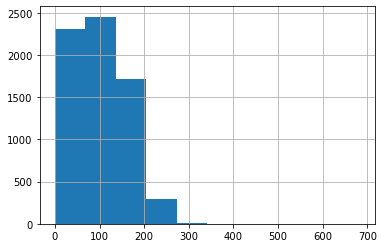

In [66]:
clean_tweets['absolute_tidy_tweets'].str.len().hist()

The histogram shows that tweets range from 0 to 250 characters and generally, 

Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each tweets.

<AxesSubplot:>

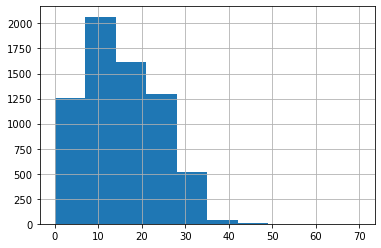

In [67]:
clean_tweets["absolute_tidy_tweets"].str.split().\
    map(lambda x: len(x)).\
    hist()

It is clear that the number of words in tweets ranges from 0 to 40 and mostly falls between 2 to 30 words.

###### 5 - Top 15 most common words

<AxesSubplot:>

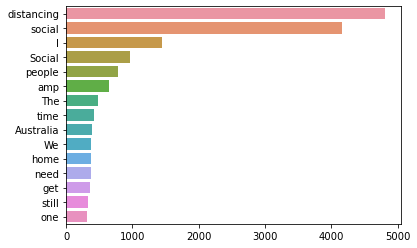

In [68]:
most_common_words(clean_tweets.absolute_tidy_tweets)

##### 6 - Extracting the Sentiments analysis

In [69]:
# Creating sentiment of the tweets one by one by calling the above function
senti=Sentiment_analysis()
sentiments=senti.perform_sentiment_function(clean_tweets)
sentiments.head(5)

date  \
0  2020-10-30 22:06:12+00:00   
1  2020-10-30 21:09:12+00:00   
2  2020-10-30 19:36:57+00:00   
3  2020-10-30 11:51:33+00:00   
4  2020-10-30 11:04:50+00:00   

                                              tweets  \
0  Social Distancing w/ @GAROFALI by @PatSupsiri ...   
1  Really impressed by @Jetstar_NZ strongly recom...   
2  @EmilyQMD Great work @EmilyQMD In Australia we...   
3  @daddylongballz @washingtonpost Population esp...   
4  Tapi ada sedikit kelakar social distancing nnt...   

                                         tidy_tweets  \
0       Social Distancing w/ @GAOFALI by @PatSupsiri   
1  eally impressed by @Jetstar_NZ strongly recomm...   
2  @EmilyQMD Great work @EmilyQMD In Australia we...   
3  @daddylongballz @washingtonpost Population esp...   
4  Tapi ada sedikit kelakar social distancing nnt...   

                                absolute_tidy_tweets sentiment  
0             Social Distancing w GAOFALI PatSupsiri   neutral  
1  eally impressed JetstarNZ strongly recommendin...       pos  
2  EmilyQMD Great work EmilyQMD In Australia weve...       pos  
3  daddylongballz washingtonpost Population espec...       pos  
4  Tapi ada sedikit kelakar social distancing nnt...   neutral

##### 7 - Graphs

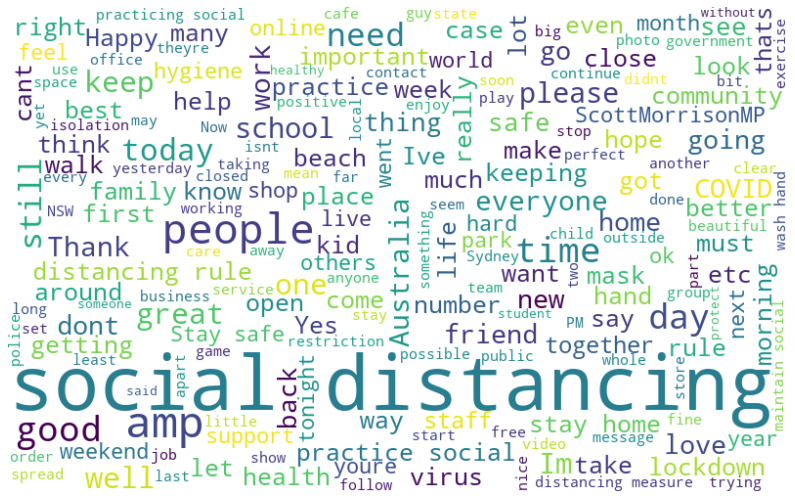

In [70]:
# Wordcloud for positive words
all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'pos']])

generate_wordcloud(all_words)

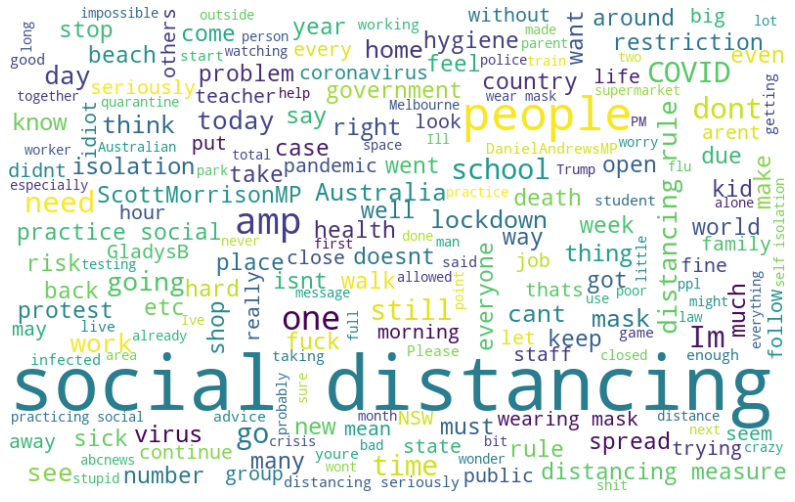

In [71]:
# negative tweets words

all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'neg']])
generate_wordcloud(all_words)

##### 8 - Total number of sentiments

<BarContainer object of 3 artists>

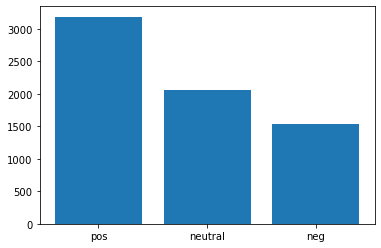

In [72]:
plt.bar(sentiments.sentiment.value_counts().index,
        sentiments.sentiment.value_counts())

##### 9 - Storing processed dataset

In [73]:
sentiments.to_csv("clean_soc_distanc_senti.csv")

In [74]:
data=pd.read_csv("clean_soc_distanc_senti.csv")

In [75]:
data.head(4)

Unnamed: 0                       date  \
0           0  2020-10-30 22:06:12+00:00   
1           1  2020-10-30 21:09:12+00:00   
2           2  2020-10-30 19:36:57+00:00   
3           3  2020-10-30 11:51:33+00:00   

                                              tweets  \
0  Social Distancing w/ @GAROFALI by @PatSupsiri ...   
1  Really impressed by @Jetstar_NZ strongly recom...   
2  @EmilyQMD Great work @EmilyQMD In Australia we...   
3  @daddylongballz @washingtonpost Population esp...   

                                         tidy_tweets  \
0       Social Distancing w/ @GAOFALI by @PatSupsiri   
1  eally impressed by @Jetstar_NZ strongly recomm...   
2  @EmilyQMD Great work @EmilyQMD In Australia we...   
3  @daddylongballz @washingtonpost Population esp...   

                                absolute_tidy_tweets sentiment  
0             Social Distancing w GAOFALI PatSupsiri   neutral  
1  eally impressed JetstarNZ strongly recommendin...       pos  
2  EmilyQMD Great work EmilyQMD In Australia weve...       pos  
3  daddylongballz washingtonpost Population espec...       pos

In [76]:
data["months"] = tweets_monthly_count(data)
data.head(4)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Unnamed: 0                       date  \
0           0  2020-10-30 22:06:12+00:00   
1           1  2020-10-30 21:09:12+00:00   
2           2  2020-10-30 19:36:57+00:00   
3           3  2020-10-30 11:51:33+00:00   

                                              tweets  \
0  Social Distancing w/ @GAROFALI by @PatSupsiri ...   
1  Really impressed by @Jetstar_NZ strongly recom...   
2  @EmilyQMD Great work @EmilyQMD In Australia we...   
3  @daddylongballz @washingtonpost Population esp...   

                                         tidy_tweets  \
0       Social Distancing w/ @GAOFALI by @PatSupsiri   
1  eally impressed by @Jetstar_NZ strongly recomm...   
2  @EmilyQMD Great work @EmilyQMD In Australia we...   
3  @daddylongballz @washingtonpost Population esp...   

                                absolute_tidy_tweets sentiment   months  
0             Social Distancing w GAOFALI PatSupsiri   neutral  2020-10  
1  eally impressed JetstarNZ strongly recommendin...       pos  2020-10  
2  EmilyQMD Great work EmilyQMD In Australia weve...       pos  2020-10  
3  daddylongballz washingtonpost Population espec...       pos  2020-10

In [77]:
summary = data.groupby(["months","sentiment"]).size()
print(summary)



months   sentiment
2020-03  neg           730
         neutral      1137
         pos          1681
2020-04  neg           341
         neutral       412
         pos           676
2020-05  neg           102
         neutral       161
         pos           275
2020-06  neg           101
         neutral        99
         pos           161
2020-07  neg           136
         neutral       127
         pos           208
2020-08  neg            61
         neutral        55
         pos            97
2020-09  neg            36
         neutral        35
         pos            46
2020-10  neg            29
         neutral        31
         pos            43
dtype: int64


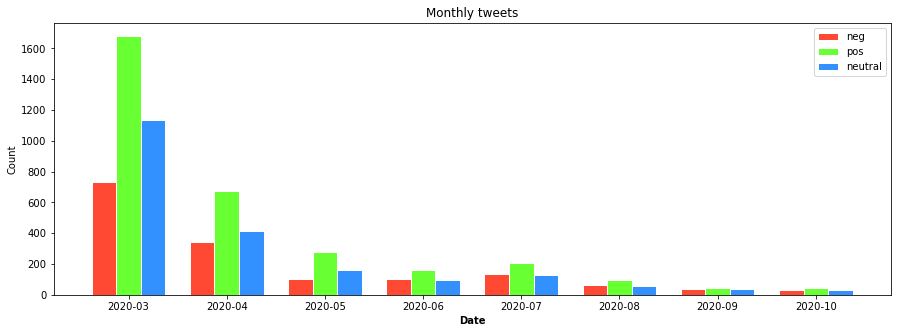

In [78]:
#Ploting the graph 
drawing_the_plot(summary)

### 5 - vaccine

In [79]:
# df_faceM = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
#     'vaccine near:"Perth" within:5000km since:2020-03-01 until:2020-10-31').get_items(), 5000))[['date', 'content']]

In [80]:
# df_vacc.to_csv('vaccine_senti.csv', index=False) #Store the collected tweets into local system 

##### 1 - Reading Raw dataset

In [81]:
raw_df=pd.read_csv("vaccine_senti.csv")
raw_df.head(3)

date  \
0  2020-10-30 21:43:08+00:00   
1  2020-10-30 15:43:24+00:00   
2  2020-10-30 14:00:59+00:00   

                                             content  
0    @tls_fletcher Hope ➕decent president ➕vaccine ✅  
1  would you date someone who..?\n\n1 - done \n2 ...  
2  @CNBC They should offer free covid vaccines to...

##### 2 - renamaing Columns

In [82]:

# As the column has no name so i am renaming the column in this code
raw_df.rename(columns = {"content":'tweets'}, inplace = True)
raw_df.head(3)

date  \
0  2020-10-30 21:43:08+00:00   
1  2020-10-30 15:43:24+00:00   
2  2020-10-30 14:00:59+00:00   

                                              tweets  
0    @tls_fletcher Hope ➕decent president ➕vaccine ✅  
1  would you date someone who..?\n\n1 - done \n2 ...  
2  @CNBC They should offer free covid vaccines to...

##### 3 - Preprocessing the data

In [83]:
# making an object of the preprocessing class

pro=Preprocessing()

# Cleaning  tweets
clean_tweets=pro.data_preprocessing(raw_df)

clean_tweets.head(5)

<ipython-input-2-a8680800a29a>:39: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


date  \
0  2020-10-30 21:43:08+00:00   
1  2020-10-30 15:43:24+00:00   
2  2020-10-30 14:00:59+00:00   
3  2020-10-30 09:37:53+00:00   
4  2020-10-30 06:36:20+00:00   

                                              tweets  \
0    @tls_fletcher Hope ➕decent president ➕vaccine ✅   
1  would you date someone who..?\n\n1 - done \n2 ...   
2  @CNBC They should offer free covid vaccines to...   
3  @MeDyoyski In Shaa Allah ate. Vaccine nalang k...   
4  Great modig \n\nPM Modi says all Indians will ...   

                                         tidy_tweets  \
0    @tls_fletcher Hope ➕decent president ➕vaccine ✅   
1  would you date someone who..? 1 - done 2 - lyf...   
2  @CNBC They should offer free covid vaccines to...   
3  @MeDyoyski In Shaa Allah ate. Vaccine nalang k...   
4  Great modig PM Modi says all Indians will get ...   

                                absolute_tidy_tweets  
0          tlsfletcher Hope decent president vaccine  
1  would date someone done lyfe dont think nahh s...  
2   CNBC They offer free covid vaccine Apple Fanboys  
3  MeDyoyski In Shaa Allah ate Vaccine nalang kulang  
4  Great modig PM Modi say Indians get coronaviru...

##### 4 - Analyzing text statistics
First, I’ll take a look at the number of characters present in each sentence. This can give us a rough idea about the tweets length.

<AxesSubplot:>

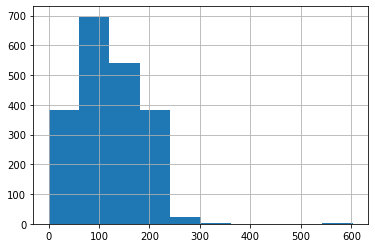

In [84]:
clean_tweets['absolute_tidy_tweets'].str.len().hist()

The histogram shows that tweets range from 0 to 250 characters and generally, 

Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each tweets.

<AxesSubplot:>

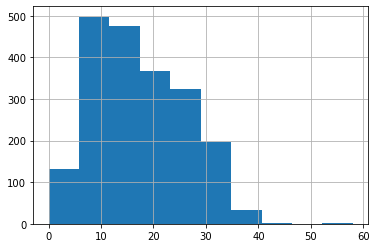

In [85]:
clean_tweets["absolute_tidy_tweets"].str.split().\
    map(lambda x: len(x)).\
    hist()

It is clear that the number of words in tweets ranges from 0 to 40 and mostly falls between 2 to 30 words.

###### 5 - Top 15 most common words

<AxesSubplot:>

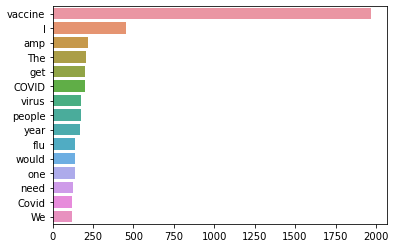

In [86]:
most_common_words(clean_tweets.absolute_tidy_tweets)

##### 6 - Extracting the Sentiments analysis

In [87]:
# Creating sentiment of the tweets one by one by calling the above function
senti=Sentiment_analysis()
sentiments=senti.perform_sentiment_function(clean_tweets)
sentiments.head(5)

date  \
0  2020-10-30 21:43:08+00:00   
1  2020-10-30 15:43:24+00:00   
2  2020-10-30 14:00:59+00:00   
3  2020-10-30 09:37:53+00:00   
4  2020-10-30 06:36:20+00:00   

                                              tweets  \
0    @tls_fletcher Hope ➕decent president ➕vaccine ✅   
1  would you date someone who..?\n\n1 - done \n2 ...   
2  @CNBC They should offer free covid vaccines to...   
3  @MeDyoyski In Shaa Allah ate. Vaccine nalang k...   
4  Great modig \n\nPM Modi says all Indians will ...   

                                         tidy_tweets  \
0    @tls_fletcher Hope ➕decent president ➕vaccine ✅   
1  would you date someone who..? 1 - done 2 - lyf...   
2  @CNBC They should offer free covid vaccines to...   
3  @MeDyoyski In Shaa Allah ate. Vaccine nalang k...   
4  Great modig PM Modi says all Indians will get ...   

                                absolute_tidy_tweets sentiment  
0          tlsfletcher Hope decent president vaccine       pos  
1  would date someone done lyfe dont think nahh s...       neg  
2   CNBC They offer free covid vaccine Apple Fanboys       pos  
3  MeDyoyski In Shaa Allah ate Vaccine nalang kulang   neutral  
4  Great modig PM Modi say Indians get coronaviru...       pos

##### 7 - Graphs

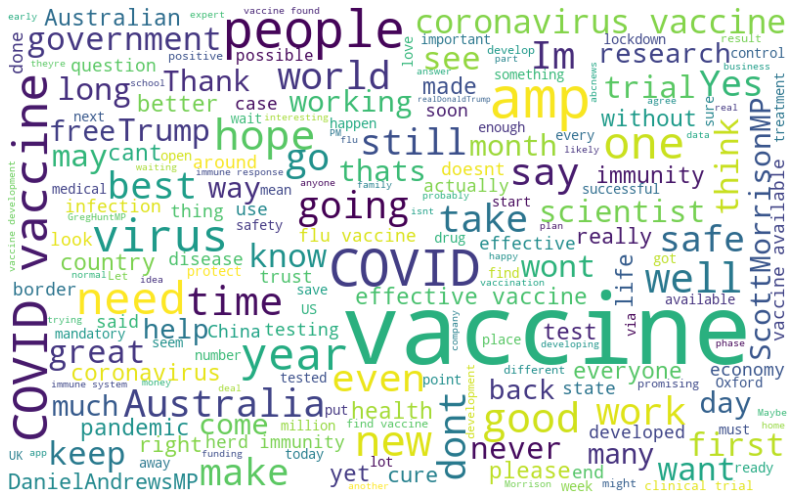

In [88]:
# Wordcloud for positive words
all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'pos']])

generate_wordcloud(all_words)

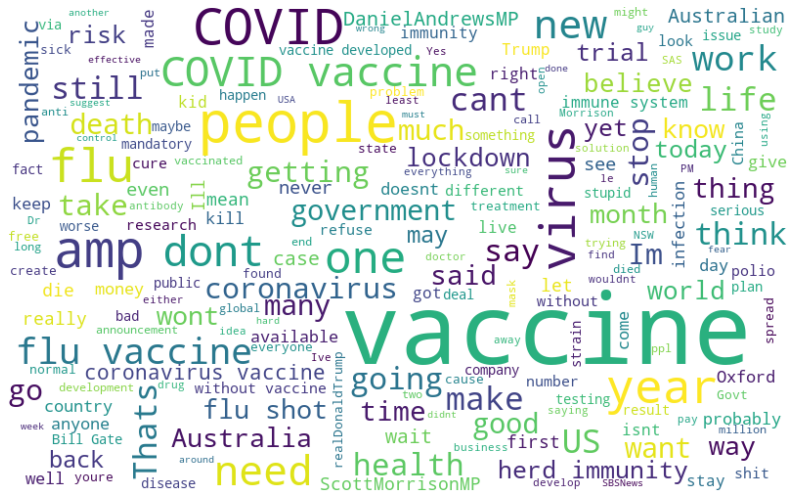

In [89]:
# negative tweets words

all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'neg']])
generate_wordcloud(all_words)

##### 8 - Total number of sentiments

<BarContainer object of 3 artists>

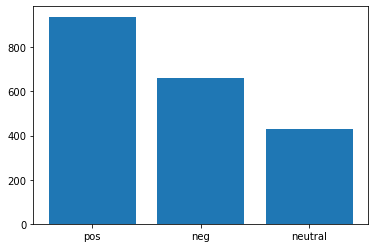

In [90]:
plt.bar(sentiments.sentiment.value_counts().index,
        sentiments.sentiment.value_counts())

##### 9 - Storing processed dataset

In [91]:
sentiments.to_csv("clean_vaccine_senti.csv")

In [92]:
data=pd.read_csv("clean_vaccine_senti.csv")

In [93]:
data.head(4)

Unnamed: 0                       date  \
0           0  2020-10-30 21:43:08+00:00   
1           1  2020-10-30 15:43:24+00:00   
2           2  2020-10-30 14:00:59+00:00   
3           3  2020-10-30 09:37:53+00:00   

                                              tweets  \
0    @tls_fletcher Hope ➕decent president ➕vaccine ✅   
1  would you date someone who..?\n\n1 - done \n2 ...   
2  @CNBC They should offer free covid vaccines to...   
3  @MeDyoyski In Shaa Allah ate. Vaccine nalang k...   

                                         tidy_tweets  \
0    @tls_fletcher Hope ➕decent president ➕vaccine ✅   
1  would you date someone who..? 1 - done 2 - lyf...   
2  @CNBC They should offer free covid vaccines to...   
3  @MeDyoyski In Shaa Allah ate. Vaccine nalang k...   

                                absolute_tidy_tweets sentiment  
0          tlsfletcher Hope decent president vaccine       pos  
1  would date someone done lyfe dont think nahh s...       neg  
2   CNBC They offer free covid vaccine Apple Fanboys       pos  
3  MeDyoyski In Shaa Allah ate Vaccine nalang kulang   neutral

In [94]:
data["months"] = tweets_monthly_count(data)
data.head(4)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Unnamed: 0                       date  \
0           0  2020-10-30 21:43:08+00:00   
1           1  2020-10-30 15:43:24+00:00   
2           2  2020-10-30 14:00:59+00:00   
3           3  2020-10-30 09:37:53+00:00   

                                              tweets  \
0    @tls_fletcher Hope ➕decent president ➕vaccine ✅   
1  would you date someone who..?\n\n1 - done \n2 ...   
2  @CNBC They should offer free covid vaccines to...   
3  @MeDyoyski In Shaa Allah ate. Vaccine nalang k...   

                                         tidy_tweets  \
0    @tls_fletcher Hope ➕decent president ➕vaccine ✅   
1  would you date someone who..? 1 - done 2 - lyf...   
2  @CNBC They should offer free covid vaccines to...   
3  @MeDyoyski In Shaa Allah ate. Vaccine nalang k...   

                                absolute_tidy_tweets sentiment   months  
0          tlsfletcher Hope decent president vaccine       pos  2020-10  
1  would date someone done lyfe dont think nahh s...       neg  2020-10  
2   CNBC They offer free covid vaccine Apple Fanboys       pos  2020-10  
3  MeDyoyski In Shaa Allah ate Vaccine nalang kulang   neutral  2020-10

In [95]:
summary = data.groupby(["months","sentiment"]).size()
print(summary)

months   sentiment
2020-03  neg           85
         neutral       51
         pos          124
2020-04  neg          124
         neutral       74
         pos          126
2020-05  neg           77
         neutral       36
         pos          103
2020-06  neg           21
         neutral       25
         pos           41
2020-07  neg           72
         neutral       59
         pos          128
2020-08  neg          164
         neutral      111
         pos          247
2020-09  neg           71
         neutral       46
         pos           97
2020-10  neg           46
         neutral       29
         pos           73
dtype: int64


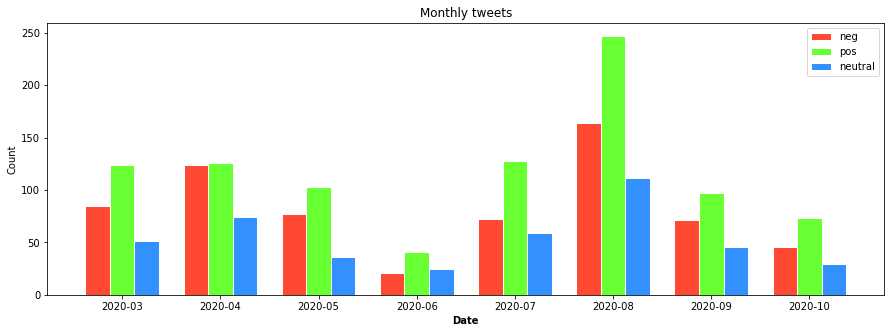

In [96]:
#Ploting the graph 
drawing_the_plot(summary)

### 6- Facemask

In [97]:
# df_face = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
#     'mask near:"Perth" within:5000km since:2020-02-29 until:2021-1-1').get_items(), 
#                                         100000))[['date', 'content']]

In [98]:
# df_face.to_csv('mask_senti.csv', index=False) #Store the collected tweets into local system 

#### 1 - Reading Raw dataset

In [99]:
raw_df=pd.read_csv("mask_senti.csv")
raw_df.head(3)

date  \
0  2020-12-31 23:46:53+00:00   
1  2020-12-31 23:22:47+00:00   
2  2020-12-31 22:46:38+00:00   

                                             content  
0  The Victorian Health Minister has clarified ru...  
1  @Michael01996367 @elonmusk @Tesla @TeslaGong @...  
2  Mask 😷 wearing deemed to be too much of a burd...

#### 2- renaming columns

In [100]:
# As the column has no name so i am renaming the column in this code
raw_df.rename(columns = {"content":'tweets'}, inplace = True)
raw_df.head(3)

date  \
0  2020-12-31 23:46:53+00:00   
1  2020-12-31 23:22:47+00:00   
2  2020-12-31 22:46:38+00:00   

                                              tweets  
0  The Victorian Health Minister has clarified ru...  
1  @Michael01996367 @elonmusk @Tesla @TeslaGong @...  
2  Mask 😷 wearing deemed to be too much of a burd...

##### 3 - Preprocessing the data

In [101]:
# making an object of the preprocessing class

pro=Preprocessing()

# Cleaning  tweets
clean_tweets=pro.data_preprocessing(raw_df)

clean_tweets.head(5)

<ipython-input-2-a8680800a29a>:39: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


date  \
0  2020-12-31 23:46:53+00:00   
1  2020-12-31 23:22:47+00:00   
2  2020-12-31 22:46:38+00:00   
3  2020-12-31 22:29:51+00:00   
4  2020-12-31 22:23:13+00:00   

                                              tweets  \
0  The Victorian Health Minister has clarified ru...   
1  @Michael01996367 @elonmusk @Tesla @TeslaGong @...   
2  Mask 😷 wearing deemed to be too much of a burd...   
3  @elonmusk @Tesla @TeslaGong @_TeslaTom @TeslaS...   
4  @noplaceforsheep Ludicrous, it takes an entire...   

                                         tidy_tweets  \
0  The Victorian Health Minister has clarified ru...   
1  @Michael01996367 @elonmusk @Tesla @TeslaGong @...   
2  Mask 😷 wearing deemed to be too much of a burd...   
3  @elonmusk @Tesla @TeslaGong @_TeslaTom @TeslaS...   
4  @noplaceforsheep Ludicrous, it takes an entire...   

                                absolute_tidy_tweets  
0  The Victorian Health Minister clarified rule a...  
1  Michael elonmusk Tesla TeslaGong TeslaTom Tesl...  
2  Mask wearing deemed much burden ppl NSW accord...  
3  elonmusk Tesla TeslaGong TeslaTom TeslaStraya ...  
4  noplaceforsheep Ludicrous take entire press co...

##### 4 - Analyzing text statistics
First, I’ll take a look at the number of characters present in each sentence. This can give us a rough idea about the tweets length.

<AxesSubplot:>

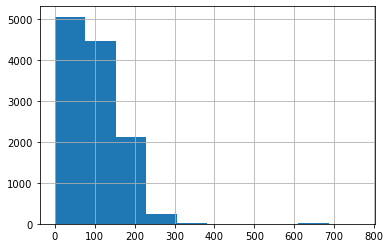

In [102]:
clean_tweets['absolute_tidy_tweets'].str.len().hist()

The histogram shows that tweets range from 0 to 250 characters and generally, 

Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each tweets.

<AxesSubplot:>

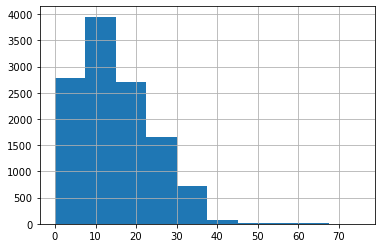

In [103]:
clean_tweets["absolute_tidy_tweets"].str.split().\
    map(lambda x: len(x)).\
    hist()

#### 5 - Top 15 most common words

<AxesSubplot:>

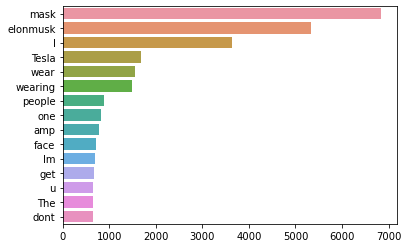

In [104]:
most_common_words(clean_tweets.absolute_tidy_tweets)

##### 6 - Extracting the Sentiments analysis

In [105]:
# Creating sentiment of the tweets one by one by calling the above function
senti=Sentiment_analysis()
sentiments=senti.perform_sentiment_function(clean_tweets)
sentiments.head(5)

date  \
0  2020-12-31 23:46:53+00:00   
1  2020-12-31 23:22:47+00:00   
2  2020-12-31 22:46:38+00:00   
3  2020-12-31 22:29:51+00:00   
4  2020-12-31 22:23:13+00:00   

                                              tweets  \
0  The Victorian Health Minister has clarified ru...   
1  @Michael01996367 @elonmusk @Tesla @TeslaGong @...   
2  Mask 😷 wearing deemed to be too much of a burd...   
3  @elonmusk @Tesla @TeslaGong @_TeslaTom @TeslaS...   
4  @noplaceforsheep Ludicrous, it takes an entire...   

                                         tidy_tweets  \
0  The Victorian Health Minister has clarified ru...   
1  @Michael01996367 @elonmusk @Tesla @TeslaGong @...   
2  Mask 😷 wearing deemed to be too much of a burd...   
3  @elonmusk @Tesla @TeslaGong @_TeslaTom @TeslaS...   
4  @noplaceforsheep Ludicrous, it takes an entire...   

                                absolute_tidy_tweets sentiment  
0  The Victorian Health Minister clarified rule a...       pos  
1  Michael elonmusk Tesla TeslaGong TeslaTom Tesl...   neutral  
2  Mask wearing deemed much burden ppl NSW accord...       neg  
3  elonmusk Tesla TeslaGong TeslaTom TeslaStraya ...       pos  
4  noplaceforsheep Ludicrous take entire press co...       neg

#### 7- Graphs

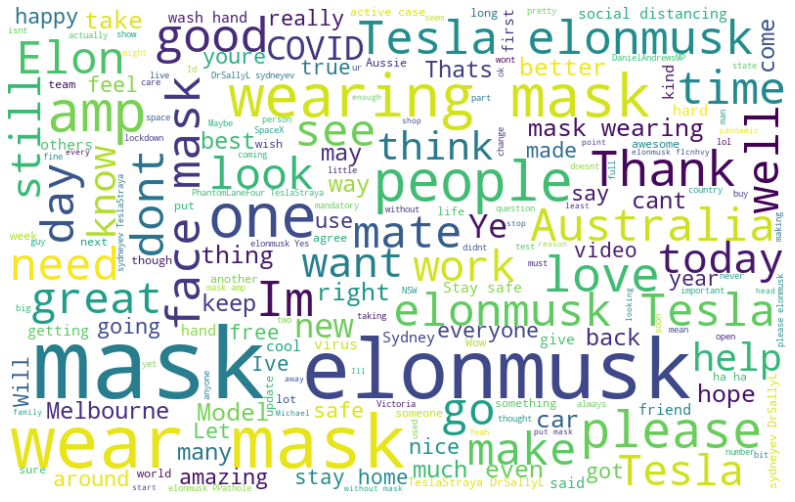

In [106]:
# Wordcloud for positive words
all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'pos']])

generate_wordcloud(all_words)

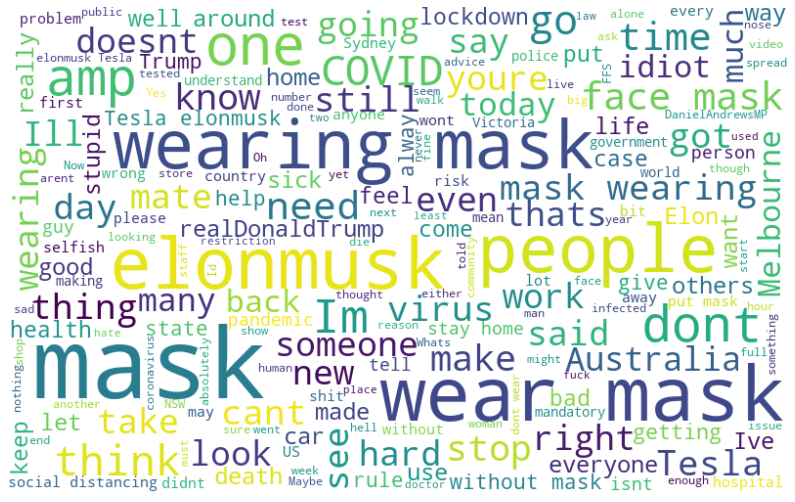

In [107]:
# negative tweets words

all_words = ' '.join([text for text in sentiments['absolute_tidy_tweets'][sentiments.sentiment == 'neg']])
generate_wordcloud(all_words)

#### 8- Total number of sentiments

<BarContainer object of 3 artists>

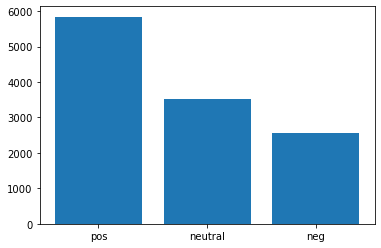

In [108]:
plt.bar(sentiments.sentiment.value_counts().index,
        sentiments.sentiment.value_counts())

#### 9 - Storing processed dataset

In [109]:
sentiments.to_csv("clean_mask_senti.csv")

In [110]:
data=pd.read_csv("clean_mask_senti.csv")

In [111]:
data.head(4)

Unnamed: 0                       date  \
0           0  2020-12-31 23:46:53+00:00   
1           1  2020-12-31 23:22:47+00:00   
2           2  2020-12-31 22:46:38+00:00   
3           3  2020-12-31 22:29:51+00:00   

                                              tweets  \
0  The Victorian Health Minister has clarified ru...   
1  @Michael01996367 @elonmusk @Tesla @TeslaGong @...   
2  Mask 😷 wearing deemed to be too much of a burd...   
3  @elonmusk @Tesla @TeslaGong @_TeslaTom @TeslaS...   

                                         tidy_tweets  \
0  The Victorian Health Minister has clarified ru...   
1  @Michael01996367 @elonmusk @Tesla @TeslaGong @...   
2  Mask 😷 wearing deemed to be too much of a burd...   
3  @elonmusk @Tesla @TeslaGong @_TeslaTom @TeslaS...   

                                absolute_tidy_tweets sentiment  
0  The Victorian Health Minister clarified rule a...       pos  
1  Michael elonmusk Tesla TeslaGong TeslaTom Tesl...   neutral  
2  Mask wearing deemed much burden ppl NSW accord...       neg  
3  elonmusk Tesla TeslaGong TeslaTom TeslaStraya ...       pos

In [112]:
data["months"] = tweets_monthly_count(data)
data.head(4)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


Unnamed: 0                       date  \
0           0  2020-12-31 23:46:53+00:00   
1           1  2020-12-31 23:22:47+00:00   
2           2  2020-12-31 22:46:38+00:00   
3           3  2020-12-31 22:29:51+00:00   

                                              tweets  \
0  The Victorian Health Minister has clarified ru...   
1  @Michael01996367 @elonmusk @Tesla @TeslaGong @...   
2  Mask 😷 wearing deemed to be too much of a burd...   
3  @elonmusk @Tesla @TeslaGong @_TeslaTom @TeslaS...   

                                         tidy_tweets  \
0  The Victorian Health Minister has clarified ru...   
1  @Michael01996367 @elonmusk @Tesla @TeslaGong @...   
2  Mask 😷 wearing deemed to be too much of a burd...   
3  @elonmusk @Tesla @TeslaGong @_TeslaTom @TeslaS...   

                                absolute_tidy_tweets sentiment   months  
0  The Victorian Health Minister clarified rule a...       pos  2020-12  
1  Michael elonmusk Tesla TeslaGong TeslaTom Tesl...   neutral  2020-12  
2  Mask wearing deemed much burden ppl NSW accord...       neg  2020-12  
3  elonmusk Tesla TeslaGong TeslaTom TeslaStraya ...       pos  2020-12

In [113]:
summary = data.groupby(["months","sentiment"]).size()
print(summary)



months   sentiment
2020-02  neg             3
         neutral         3
         pos             5
2020-03  neg           174
         neutral       229
         pos           441
2020-04  neg           233
         neutral       508
         pos           794
2020-05  neg           165
         neutral       276
         pos           467
2020-06  neg           102
         neutral       197
         pos           311
2020-07  neg           686
         neutral       752
         pos          1235
2020-08  neg           296
         neutral       355
         pos           569
2020-09  neg           172
         neutral       284
         pos           395
2020-10  neg           283
         neutral       391
         pos           548
2020-11  neg           220
         neutral       221
         pos           478
2020-12  neg           239
         neutral       300
         pos           601
dtype: int64


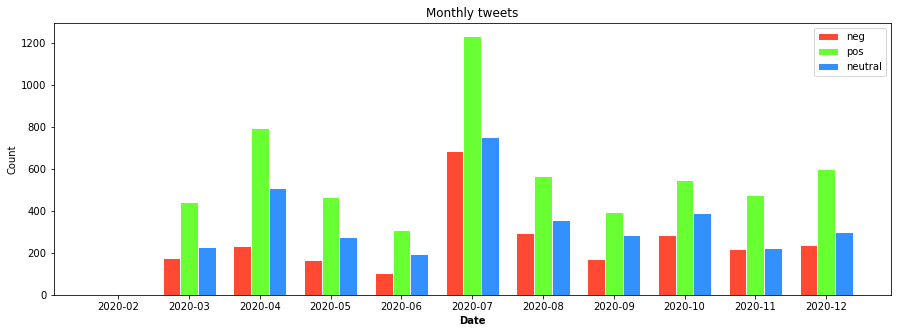

In [114]:
#Plotting the graph 
drawing_the_plot(summary)